In [2]:
import elasticsearch
print(elasticsearch.__version__)


(8, 15, 1)


In [4]:
from datasets import load_dataset
import pandas as pd

wiki = load_dataset("wikimedia/wikipedia", "20231101.en", split="train")
# Sample 0.1% of the data
sample_size = int(0.001 * len(wiki))
wiki_sample = wiki.select(range(sample_size))
df = pd.DataFrame({'text': list(wiki_sample['text'])})
print("Dataset size:", len(df))
df.head(3)


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

Dataset size: 6407


,text
0,Anarchism is a political philosophy and moveme...
1,Albedo (; ) is the fraction of sunlight that i...
2,"A, or a, is the first letter and the first vow..."


In [5]:
import re
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download NLTK data (first run only)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation & special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenize
    tokens = word_tokenize(text)
    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # 5. Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply to a manageable subset first
subset = df.head(5000).copy()

tqdm.pandas()
subset['clean_text'] = subset['text'].progress_apply(preprocess_text)

subset.to_csv("cleaned_wiki.csv", index=False)
print("✅ Preprocessing done safely.")


[nltk_data] Downloading package punkt to /home/navdha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/navdha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/navdha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 5000/5000 [01:19<00:00, 63.10it/s] 


✅ Preprocessing done safely.


In [4]:
# es_bulk_index.py
from elasticsearch import Elasticsearch, helpers
import pandas as pd
import time

# connect (fill your password)
es = Elasticsearch(
    hosts=["https://localhost:9200"],
    basic_auth=("elastic", "oHRdNMmqOk4t+KO9cbIi"),
    verify_certs=False
)
INDEX_NAME = "esindex-v1.0"

# Create index with simple mapping if doesn't exist
if es.indices.exists(index=INDEX_NAME):
    print("Index exists — deleting and recreating for a clean baseline.")
    es.indices.delete(index=INDEX_NAME)
mapping = {
  "mappings": {
    "properties": {
      "text": {"type": "text"}
    }
  }
}
es.indices.create(index=INDEX_NAME, body=mapping)

def bulk_index_chunked(df, index_name, chunk_size=500):
    total = len(df)
    for start in range(0, total, chunk_size):
        chunk = df.iloc[start:start+chunk_size]
        actions = [
            {"_index": index_name, "_id": int(idx), "_source": {"text": txt}}
            for idx, txt in zip(chunk.index, chunk['clean_text'])
        ]
        t0 = time.time()
        helpers.bulk(es, actions)
        print(f"Indexed docs {start}..{min(start+chunk_size-1,total-1)} in {time.time()-t0:.2f}s")

# Use only subset if you want (safer): e.g., subset = df.head(5000)
bulk_index_chunked(subset, INDEX_NAME, chunk_size=500)


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/elasticsearch/_sync/client/__init__.py:400: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Index exists — deleting and recreating for a clean baseline.


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#t

Indexed docs 0..499 in 0.86s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 500..999 in 0.49s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 1000..1499 in 0.40s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 1500..1999 in 0.45s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 2000..2499 in 0.56s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 2500..2999 in 0.48s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 3000..3499 in 0.28s
Indexed docs 3500..3999 in 0.14s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Indexed docs 4000..4499 in 0.19s
Indexed docs 4500..4999 in 0.20s


/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


/tmp/ipykernel_5526/1400469601.py:93: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  es.search(index=index_name, body={"query": parse_boolean_query(q)}, size=1)
/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/navdha/PycharmProjects/pythonProject/.venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



=== PERFORMANCE SUMMARY ===
Latency percentiles (seconds): p50, p95, p99: [0.01861072 0.03090224 0.03302312]
Throughput (queries/sec): 48.99
Client Memory (MB): Min=961.29, Max=961.79, Mean=961.51
Elasticsearch Memory (MB): Min=1170.83, Max=1182.20, Mean=1178.23
Memory footprint increase (Client): 1.00 MB
✅ Metrics saved to es_metrics.csv
✅ Memory usage logged to memory_usage_log.csv


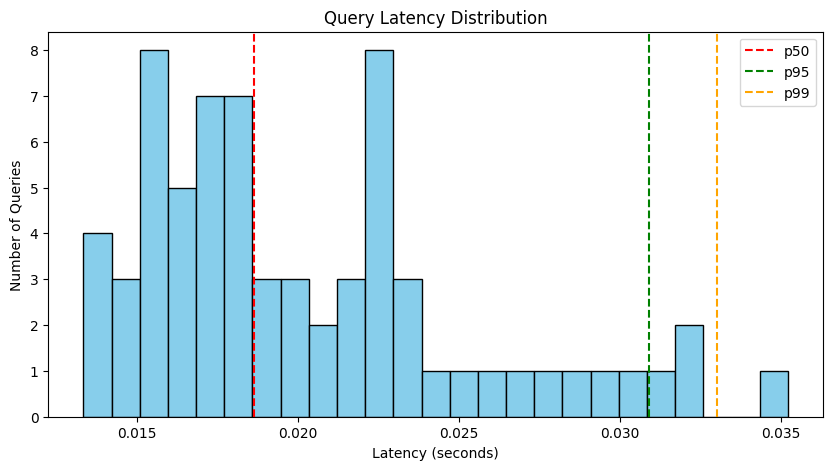

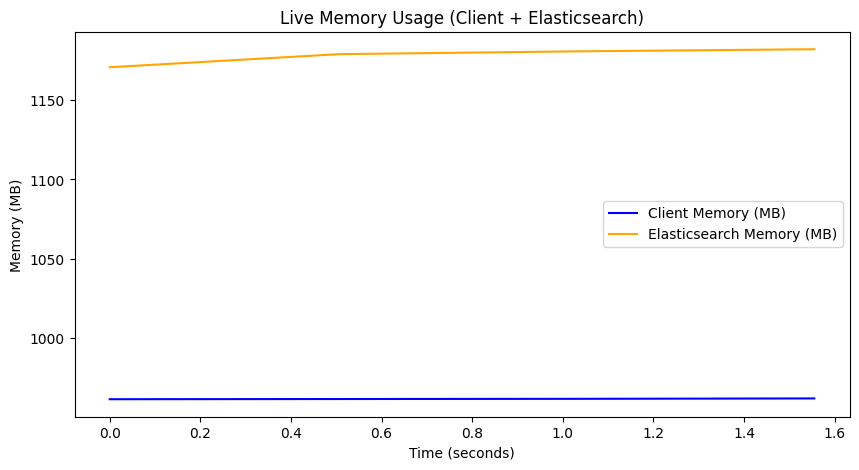

In [5]:
import time
import numpy as np
from tqdm import tqdm
import psutil
import os
import gc
import matplotlib.pyplot as plt
import pandas as pd
import threading
import subprocess

# --- Boolean Query Parser ---
def parse_boolean_query(query):
    query = query.strip()
    if query.startswith("(") and query.endswith(")"):
        return parse_boolean_query(query[1:-1].strip())
    if query.upper().startswith("NOT "):
        inner = parse_boolean_query(query[4:].strip())
        return {"bool": {"must_not": [inner]}}
    # Split by OR
    parts, depth, last, i = [], 0, 0, 0
    while i < len(query):
        if query[i] == "(": depth += 1
        elif query[i] == ")": depth -= 1
        elif depth == 0 and query[i:i+3].upper() == "OR ":
            parts.append(query[last:i].strip())
            last = i + 3
            i += 2
        i += 1
    if parts:
        parts.append(query[last:].strip())
        return {"bool": {"should": [parse_boolean_query(p) for p in parts], "minimum_should_match": 1}}
    # Split by AND
    parts, depth, last, i = [], 0, 0, 0
    while i < len(query):
        if query[i] == "(": depth += 1
        elif query[i] == ")": depth -= 1
        elif depth == 0 and query[i:i+4].upper() == "AND ":
            parts.append(query[last:i].strip())
            last = i + 4
            i += 3
        i += 1
    if parts:
        parts.append(query[last:].strip())
        return {"bool": {"must": [parse_boolean_query(p) for p in parts]}}
    # TERM or PHRASE
    query = query.strip('"')
    return {"match_phrase": {"text": query}} if " " in query else {"match": {"text": query}}

# --- Helper to find Elasticsearch process ---
def get_es_process():
    # First try finding process by name
    es_processes = []
    for p in psutil.process_iter(['pid', 'name', 'memory_info']):
        try:
            if 'java' in p.info['name'].lower():
                # Check command line for Elasticsearch
                if 'elasticsearch' in ' '.join(p.cmdline()).lower():
                    es_processes.append(p)
        except (psutil.NoSuchProcess, psutil.AccessDenied):
            continue
    if not es_processes:
        return None
    # Return the process using the maximum memory
    return max(es_processes, key=lambda x: x.memory_info().rss)

# --- Memory monitor thread ---
def monitor_memory(stop_event, log_path, interval=0.5):
    process_client = psutil.Process(os.getpid())
    process_es = get_es_process()
    records = []
    while not stop_event.is_set():
        client_mem = process_client.memory_info().rss / (1024 * 1024)
        es_mem = process_es.memory_info().rss / (1024 * 1024) if process_es else np.nan
        records.append((time.time(), client_mem, es_mem))
        time.sleep(interval)
    pd.DataFrame(records, columns=["timestamp", "client_MB", "elasticsearch_MB"]).to_csv(log_path, index=False)

# --- Measure metrics ---
def measure_metrics(es, index_name, queries, size=10):
    latencies, results = [], []
    gc.collect()
    stop_event = threading.Event()
    log_path = "memory_usage_log.csv"
    monitor_thread = threading.Thread(target=monitor_memory, args=(stop_event, log_path))
    monitor_thread.start()

    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024 * 1024)

    # Warmup
    for q in queries[:3]:
        es.search(index=index_name, body={"query": parse_boolean_query(q)}, size=1)

    start_time = time.time()
    for q in tqdm(queries, desc="Running queries"):
        es_query = parse_boolean_query(q)
        t0 = time.time()
        res = es.search(index=index_name, body={"query": es_query}, size=size)
        latencies.append(time.time() - t0)
        results.append(res)
    total_time = time.time() - start_time

    gc.collect()
    end_mem = process.memory_info().rss / (1024 * 1024)
    stop_event.set()
    monitor_thread.join()

    mem_usage = max(0, end_mem - start_mem)
    throughput = len(queries) / total_time
    return np.array(latencies), throughput, mem_usage, results, log_path

# --- Load queries ---
queries = [line.strip() for line in open("queries.txt") if line.strip()]

# --- Run metrics ---
latencies, throughput, mem_usage, results, log_path = measure_metrics(es, INDEX_NAME, queries)

# --- Print summary ---
print("\n=== PERFORMANCE SUMMARY ===")
print("Latency percentiles (seconds): p50, p95, p99:", np.percentile(latencies, [50, 95, 99]))
print(f"Throughput (queries/sec): {throughput:.2f}")

mem_df = pd.read_csv(log_path)
print(f"Client Memory (MB): Min={mem_df['client_MB'].min():.2f}, Max={mem_df['client_MB'].max():.2f}, Mean={mem_df['client_MB'].mean():.2f}")
if mem_df['elasticsearch_MB'].notna().any():
    print(f"Elasticsearch Memory (MB): Min={mem_df['elasticsearch_MB'].min():.2f}, Max={mem_df['elasticsearch_MB'].max():.2f}, Mean={mem_df['elasticsearch_MB'].mean():.2f}")
else:
    print("Elasticsearch process not found — skipping server memory.")

print(f"Memory footprint increase (Client): {mem_usage:.2f} MB")
print("✅ Metrics saved to es_metrics.csv")
print("✅ Memory usage logged to memory_usage_log.csv")

# --- Save metrics ---
pd.DataFrame({"query": queries, "latency_sec": latencies}).to_csv("es_metrics.csv", index=False)

# --- Plot latency histogram ---
plt.figure(figsize=(10,5))
plt.hist(latencies, bins=25, color='skyblue', edgecolor='black')
plt.title("Query Latency Distribution")
plt.xlabel("Latency (seconds)")
plt.ylabel("Number of Queries")
plt.axvline(np.percentile(latencies, 50), color='red', linestyle='--', label='p50')
plt.axvline(np.percentile(latencies, 95), color='green', linestyle='--', label='p95')
plt.axvline(np.percentile(latencies, 99), color='orange', linestyle='--', label='p99')
plt.legend()
plt.show()

# --- Plot memory usage ---
plt.figure(figsize=(10,5))
plt.plot(mem_df["timestamp"] - mem_df["timestamp"].min(), mem_df["client_MB"], label="Client Memory (MB)", color="blue")
if mem_df["elasticsearch_MB"].notna().any():
    plt.plot(mem_df["timestamp"] - mem_df["timestamp"].min(), mem_df["elasticsearch_MB"], label="Elasticsearch Memory (MB)", color="orange")
plt.title("Live Memory Usage (Client + Elasticsearch)")
plt.xlabel("Time (seconds)")
plt.ylabel("Memory (MB)")
plt.legend()
plt.show()


In [2]:
VERSION_CONFIG = {
    "v1.x1.y2.z2.i0.qT0": {
        "info": "BOOLEAN", "dstore": "DB1", "compr": "CODE", "optim": "Null", "qproc": "TERMatat"
    },
    "v1.x1.y3.z3.i0.qT0": {
        "info": "BOOLEAN", "dstore": "DB2", "compr": "CLIB", "optim": "Null", "qproc": "TERMatat"
    },
    # Add all other combinations as needed
}


In [7]:
# selfindex_impl.py
# Drop into a notebook cell or a .py file and run/import it.

import sqlite3
import json
import pickle
import math
import shutil
from collections import defaultdict
from typing import Iterable, List, Tuple, Dict, Set
from pathlib import Path
import zlib
import lzma

# reuse the Enum classes from your boilerplate or redefine minimal ones here
from enum import Enum
class IndexInfo(Enum):
    BOOLEAN = 1
    WORDCOUNT = 2
    TFIDF = 3
class DataStore(Enum):
    CUSTOM = 1
    DB1 = 2
    DB2 = 3
class Compression(Enum):
    NONE = 1
    CODE = 2
    CLIB = 3
class QueryProc(Enum):
    TERMatat = 'T'   # Term-at-a-time
    DOCatat = 'D'    # Doc-at-a-time
class Optimizations(Enum):
    Null = '0'
    Skipping = 'sp'
    Thresholding = 'th'
    EarlyStopping = 'es'

# Simple boolean query parser -> AST similar to our previous parse_boolean_query but adapted
def parse_boolean_query_to_ast(query: str):
    """Parse a query string into a simple AST:
       - {"match": "word"} for single term
       - {"match_phrase": "a b"} for phrase
       - {"bool": {"must": [expr,...]}} OR {"bool":{"should":[...]}} OR {"bool":{"must_not":[...]}}
    """
    q = query.strip()
    # strip outer parentheses
    if q.startswith("(") and q.endswith(")"):
        # check balanced parentheses inside before trimming aggressively
        depth = 0
        balanced = True
        for i, ch in enumerate(q):
            if ch == "(":
                depth += 1
            elif ch == ")":
                depth -= 1
                if depth == 0 and i != len(q)-1:
                    balanced = False
                    break
        if balanced:
            return parse_boolean_query_to_ast(q[1:-1].strip())

    # NOT at top
    if q.upper().startswith("NOT "):
        inner = parse_boolean_query_to_ast(q[4:].strip())
        return {"bool": {"must_not": [inner]}}

    # top-level OR split
    parts = []
    depth = 0
    last = 0
    i = 0
    while i < len(q):
        if q[i] == "(":
            depth += 1
        elif q[i] == ")":
            depth -= 1
        elif depth == 0 and q[i:i+3].upper() == "OR ":
            parts.append(q[last:i].strip())
            last = i + 3
            i += 2
        i += 1
    if parts:
        parts.append(q[last:].strip())
        return {"bool": {"should": [parse_boolean_query_to_ast(p) for p in parts], "minimum_should_match": 1}}

    # top-level AND split
    parts = []
    depth = 0
    last = 0
    i = 0
    while i < len(q):
        if q[i] == "(":
            depth += 1
        elif q[i] == ")":
            depth -= 1
        elif depth == 0 and q[i:i+4].upper() == "AND ":
            parts.append(q[last:i].strip())
            last = i + 4
            i += 3
        i += 1
    if parts:
        parts.append(q[last:].strip())
        return {"bool": {"must": [parse_boolean_query_to_ast(p) for p in parts]}}

    # TERM or PHRASE
    if q.startswith('"') and q.endswith('"'):
        phrase = q.strip('"')
        return {"match_phrase": phrase}
    # treat if contains spaces but no quotes as phrase too
    if " " in q:
        return {"match_phrase": q}
    return {"match": q}


class SelfIndex:
    """
    Simple SelfIndex implementation (pickled storage).
    Supports index variants: BOOLEAN / WORDCOUNT / TFIDF
    Query processors: TERMatat, DOCatat
    Persistence: folder per index_id under base_dir
    """
    base_dir = Path("./selfindex_store")
    
    def __init__(self, version: str = None):
    # default placeholders if version not given
     self.core = "SelfIndex"
     if version and version in VERSION_CONFIG:
        cfg = VERSION_CONFIG[version]
        self.info = IndexInfo[cfg["info"]]
        self.dstore = DataStore[cfg["dstore"]]
        self.compr = Compression[cfg["compr"]]
        self.optim = Optimizations[cfg["optim"]]
        self.qproc = QueryProc[cfg["qproc"]]
     else:
        # defaults
        self.info = IndexInfo.BOOLEAN
        self.dstore = DataStore.CUSTOM
        self.compr = Compression.NONE
        self.optim = Optimizations.Null
        self.qproc = QueryProc.TERMatat

    # runtime structures
     self.postings: Dict[str, List[Tuple[int,int,List[int]]]] = {}
     self.doc_len: Dict[int,int] = {}
     self.df: Dict[str,int] = {}
     self.N: int = 0
     self.index_id: str = None
     self.index_path: Path = None
     self.doc_ids_indexed: List[int] = []

     SelfIndex.base_dir.mkdir(parents=True, exist_ok=True)
     self.stemmer = PorterStemmer()

    # ------------------------
    # Persistence helpers
    # ------------------------
        # ------------------------
    # Compression utilities
    # ------------------------
    def _compress_postings(self, postings: Dict) -> bytes:
        """Compress postings dictionary according to chosen compression method."""
        data = pickle.dumps(postings, protocol=pickle.HIGHEST_PROTOCOL)
        if self.compr == Compression.NONE:
            return data
        elif self.compr == Compression.CODE:
            # Simple compression with zlib
            return zlib.compress(data, level=9)
        elif self.compr == Compression.CLIB:
            # Stronger compression using lzma (off-the-shelf library)
            return lzma.compress(data)
        else:
            raise ValueError(f"Unknown compression type: {self.compr}")

    def _decompress_postings(self, data: bytes) -> Dict:
        """Decompress postings according to chosen compression method."""
        if self.compr == Compression.NONE:
            raw = data
        elif self.compr == Compression.CODE:
            raw = zlib.decompress(data)
        elif self.compr == Compression.CLIB:
            raw = lzma.decompress(data)
        else:
            raise ValueError(f"Unknown compression type: {self.compr}")
        return pickle.loads(raw)

# ------------------ DB1: SQLite ------------------
    def _save_postings_db1(self, postings, folder):
     db_path = Path(folder) / "postings.db"
     if db_path.exists():
        db_path.unlink()
     conn = sqlite3.connect(db_path)
     cur = conn.cursor()
     cur.execute("CREATE TABLE postings(term TEXT PRIMARY KEY, data BLOB)")

     for term, plist in postings.items():
        # compress per-term if needed
        data = pickle.dumps(plist, protocol=pickle.HIGHEST_PROTOCOL)
        if self.compr == Compression.CODE:
            data = zlib.compress(data)
        elif self.compr == Compression.CLIB:
            data = lzma.compress(data)
        # store in DB
        cur.execute("INSERT INTO postings VALUES(?, ?)", (term, data))

     conn.commit()
     conn.close()

    def _load_postings_db1(self, folder):
     db_path = Path(folder) / "postings.db"
     conn = sqlite3.connect(db_path)
     cur = conn.cursor()
     postings = {}

     for term, blob in cur.execute("SELECT term, data FROM postings"):
        if self.compr == Compression.CODE:
            blob = zlib.decompress(blob)
        elif self.compr == Compression.CLIB:
            blob = lzma.decompress(blob)
        plist = pickle.loads(blob)
        postings[term] = plist

     conn.close()
     return postings

# ------------------ DB2: JSON-lines ------------------
    def _save_postings_db2(self, postings, folder):
     file_path = Path(folder) / "postings.jsonl"
     with open(file_path, "wb") as f:  # open in binary for compressed writes
        for term, plist in postings.items():
            data = pickle.dumps(plist, protocol=pickle.HIGHEST_PROTOCOL)
            if self.compr == Compression.CODE:
                data = zlib.compress(data)
            elif self.compr == Compression.CLIB:
                data = lzma.compress(data)
            # write as length-prefixed record for safe JSONL-like reading
            # format: <len_bytes(4)><data>
            f.write(len(data).to_bytes(4, "big") + data)

    def _load_postings_db2(self, folder):
     file_path = Path(folder) / "postings.jsonl"
     postings = {}
     with open(file_path, "rb") as f:
        while True:
            len_bytes = f.read(4)
            if not len_bytes:
                break
            data_len = int.from_bytes(len_bytes, "big")
            data = f.read(data_len)
            if self.compr == Compression.CODE:
                data = zlib.decompress(data)
            elif self.compr == Compression.CLIB:
                data = lzma.decompress(data)
            plist = pickle.loads(data)
            # retrieve term from plist (original key)
            # DB2 already writes term separately in JSON, so here we assume plist is just list
            # store using first element's term if needed; or keep a dict {term: plist} before saving
            # simpler: store as {term: plist}
            # for DB2, we need to save term explicitly:
            term = plist[0][0] if plist else None
            if term is not None:
                postings[term] = plist
     return postings


    def _index_folder(self, index_id: str) -> Path:
        return SelfIndex.base_dir / index_id

    def _meta_path(self, index_id: str) -> Path:
        return self._index_folder(index_id) / "meta.json"

    def _postings_path(self, index_id: str) -> Path:
        return self._index_folder(index_id) / "postings.pkl"

    # ------------------------
    # Create index
    # ------------------------
    def create_index(self, index_id: str, files: Iterable[Tuple[str,str]]) -> None:
        """
        files: iterable of (doc_id_str, content_str)
        doc_id_str should be convertible to int or unique string; we'll convert to int if possible.
        """
        print(f"[SelfIndex] Building index '{index_id}' with config info={self.info.name}, dstore={self.dstore.name}, optim={self.optim.name}, compr={self.compr.name}, qproc={self.qproc.name}")
        # init
        temp = defaultdict(lambda: defaultdict(list))  # token -> doc -> list of positions
        doc_len = {}
        doc_ids = []

        # ingest
        for doc_id_raw, text in files:
            try:
                doc_id = int(doc_id_raw)
            except:
                # fallback: use hash
                doc_id = abs(hash(doc_id_raw)) % (10**9)
            doc_ids.append(doc_id)
            tokens = self._tokenize(text)
            doc_len[doc_id] = len(tokens)
            for pos, tok in enumerate(tokens):
                temp[tok][doc_id].append(pos)

        # convert temp -> postings lists
        postings = {}
        df = {}
        for tok, dmap in temp.items():
            plist = []
            for doc in sorted(dmap.keys()):
                positions = dmap[doc]
                freq = len(positions)
                plist.append((doc, freq, positions))
            postings[tok] = plist
            df[tok] = len(plist)

        # metadata
        N = len(doc_len)

        # compute TF-IDF weights if requested (we will store df and doc_len and calculate on-the-fly)
        # store state
        folder = self._index_folder(index_id)
        if folder.exists():
            print("[SelfIndex] Warning: index folder exists. Overwriting.")
            shutil.rmtree(folder)
        folder.mkdir(parents=True, exist_ok=True)

        # persist postings (pickle) and metadata (json)
        #with open(self._postings_path(index_id), "wb") as f:
            #pickle.dump(postings, f, protocol=pickle.HIGHEST_PROTOCOL)
        compressed_data = self._compress_postings(postings)
        #with open(self._postings_path(index_id), "wb") as f:
         #f.write(compressed_data)
        if self.dstore == DataStore.CUSTOM:
          with open(folder / "postings.pkl", "wb") as f:
           f.write(compressed_data)
        elif self.dstore == DataStore.DB1:
          self._save_postings_db1(postings, folder)
        elif self.dstore == DataStore.DB2:
          self._save_postings_db2(postings, folder)


        meta = {
            "info": self.info.name,
            "dstore": self.dstore.name,
            "qproc": self.qproc.name,
            "compr": self.compr.name,
            "optim": self.optim.name,
            "N": N,
            "df": df,
            "doc_len": doc_len,
            "doc_ids": doc_ids
        }
        with open(self._meta_path(index_id), "w", encoding="utf8") as f:
            json.dump(meta, f)

        # update instance if desired to keep loaded
        self.index_id = index_id
        self.index_path = folder
        self.postings = postings
        self.df = df
        self.doc_len = doc_len
        self.N = N
        self.doc_ids_indexed = doc_ids

        print(f"[SelfIndex] Index '{index_id}' created: {N} documents, {len(postings)} terms.")

    # ------------------------
    # Load index into memory
    # ------------------------
    def load_index(self, serialized_index_dump: str) -> None:
        """
        serialized_index_dump: path to the folder that contains postings.pkl and meta.json
        """
        folder = Path(serialized_index_dump)
        if not folder.exists():
            raise FileNotFoundError(f"Index folder not found: {serialized_index_dump}")
        # load meta
        with open(folder / "meta.json", "r", encoding="utf8") as f:
            meta = json.load(f)
        
         # update config if present
        if "compr" in meta:
            self.compr = Compression[meta["compr"]]
        if "info" in meta:
            self.info = IndexInfo[meta["info"]]
        if "qproc" in meta:
            self.qproc = QueryProc[meta["qproc"]]
        if "optim" in meta:
            self.optim = Optimizations[meta["optim"]]
        if "dstore" in meta:
            self.dstore = DataStore[meta["dstore"]]
        
        # load postings
        #with open(folder / "postings.pkl", "rb") as f:
            #postings = pickle.load(f)
        if self.dstore == DataStore.CUSTOM:
         with open(folder / "postings.pkl", "rb") as f:
          data = f.read()
         postings = self._decompress_postings(data)
        elif self.dstore == DataStore.DB1:
         postings = self._load_postings_db1(folder)
        elif self.dstore == DataStore.DB2:
         postings = self._load_postings_db2(folder)

        # set instance state (note: assume meta consistent with this instance)
        self.index_id = folder.name
        self.index_path = folder
        self.postings = postings
        self.df = meta.get("df", {})
        self.doc_len = meta.get("doc_len", {})
        self.N = meta.get("N", len(self.doc_len))
        self.doc_ids_indexed = meta.get("doc_ids", list(self.doc_len.keys()))
        
        print(f"[SelfIndex] Loaded index '{self.index_id}' (N={self.N}, terms={len(self.postings)})")

    # ------------------------
    # Update index: remove/add docs
    # ------------------------
    def update_index(self, index_id: str, remove_files: Iterable[Tuple[str, str]], add_files: Iterable[Tuple[str, str]]) -> None:
        """
        Removes then adds — simple but inefficient approach: load postings, apply changes in memory, re-persist.
        """
        # load current
        self.load_index(str(self._index_folder(index_id)))
        postings = self.postings
        # remove docs
        remove_ids = []
        for doc_id_raw, _ in remove_files:
            try:
                remove_id = int(doc_id_raw)
            except:
                remove_id = abs(hash(doc_id_raw)) % (10**9)
            remove_ids.append(remove_id)
        if remove_ids:
            for tok in list(postings.keys()):
                new_pl = [tup for tup in postings[tok] if tup[0] not in remove_ids]
                if new_pl:
                    postings[tok] = new_pl
                else:
                    del postings[tok]
            # update doc_len and df
            for rid in remove_ids:
                if rid in self.doc_len:
                    del self.doc_len[rid]
            self.N = len(self.doc_len)
        # add docs (reuse create logic for tokens -> update postings)
        for doc_id_raw, text in add_files:
            try:
                doc_id = int(doc_id_raw)
            except:
                doc_id = abs(hash(doc_id_raw)) % (10**9)
            tokens = self._tokenize(text)
            self.doc_len[doc_id] = len(tokens)
            for pos, tok in enumerate(tokens):
                # find if term exists
                if tok not in postings:
                    postings[tok] = [(doc_id, 1, [pos])]
                else:
                    # append or update last entry if same doc
                    if postings[tok] and postings[tok][-1][0] == doc_id:
                        # update freq and positions
                        old_doc, old_freq, old_pos = postings[tok][-1]
                        old_pos.append(pos)
                        postings[tok][-1] = (old_doc, old_freq+1, old_pos)
                    else:
                        postings[tok].append((doc_id, 1, [pos]))
        # recompute df
        self.df = {tok: len(plist) for tok, plist in postings.items()}
        self.postings = postings
        self.N = len(self.doc_len)
        # persist
        #compressed_data = self._compress_postings(self.postings)
        #with open(self._postings_path(index_id), "wb") as f:
         #f.write(compressed_data)
        folder = self._index_folder(index_id)
        if self.dstore == DataStore.CUSTOM:
         compressed_data = self._compress_postings(self.postings)
         with open(folder / "postings.pkl", "wb") as f:
            f.write(compressed_data)
        elif self.dstore == DataStore.DB1:
         self._save_postings_db1(self.postings, folder)
        elif self.dstore == DataStore.DB2:
         self._save_postings_db2(self.postings, folder)
        else:
         raise ValueError(f"Unknown datastore type: {self.dstore}")

        meta = {
            "info": self.info.name,
            "dstore": self.dstore.name,
            "qproc": self.qproc.name,
            "compr": self.compr.name,
            "optim": self.optim.name,
            "N": self.N,
            "df": self.df,
            "doc_len": self.doc_len,
            "doc_ids": self.doc_ids_indexed
        }
        with open(self._meta_path(index_id), "w", encoding="utf8") as f:
            json.dump(meta, f)
        print(f"[SelfIndex] Updated index '{index_id}': N={self.N} documents, terms={len(self.postings)}")

    # ------------------------
    # Delete index
    # ------------------------
    def delete_index(self, index_id: str) -> None:
     folder = self._index_folder(index_id)
     if not folder.exists():
        print(f"[SelfIndex] Index '{index_id}' not found.")
        return

    # Remove specific datastore files if needed
     try:
        if self.dstore == DataStore.CUSTOM:
            file_path = folder / "postings.pkl"
            if file_path.exists():
                file_path.unlink()
        elif self.dstore == DataStore.DB1:
            file_path = folder / "postings.db"
            if file_path.exists():
                file_path.unlink()
        elif self.dstore == DataStore.DB2:
            file_path = folder / "postings.jsonl"
            if file_path.exists():
                file_path.unlink()

        # Delete meta file and folder
        meta_path = folder / "meta.json"
        if meta_path.exists():
            meta_path.unlink()

        shutil.rmtree(folder)
        print(f"[SelfIndex] Deleted index '{index_id}'.")
     except Exception as e:
        print(f"[SelfIndex] Failed to delete index '{index_id}': {e}")

    # ------------------------
    # List indices and files
    # ------------------------
    @staticmethod
    def list_indices() -> Iterable[str]:
        base = SelfIndex.base_dir
        if not base.exists():
            return []
        return [p.name for p in base.iterdir() if p.is_dir()]

    def list_indexed_files(self, index_id: str) -> Iterable[str]:
        folder = self._index_folder(index_id)
        meta_p = folder / "meta.json"
        if not meta_p.exists():
            return []
        with open(meta_p, "r", encoding="utf8") as f:
            meta = json.load(f)
        # doc_ids stored; return as strings
        return [str(d) for d in meta.get("doc_ids", [])]

    # ------------------------
    # Query support
    # ------------------------
    def query(self, query_str: str, k: int = 10) -> Dict:
        """
        Main query entrypoint. Returns a JSON-serializable dict:
        {"query": query_str, "hits": [{"doc_id":..., "score":...}, ...], "total": X}
        """
        if not self.postings:
            raise RuntimeError("No index loaded. Call load_index() or create_index() first.")
        ast = parse_boolean_query_to_ast(query_str)
        # evaluate boolean AST to get candidate set (for boolean ops)
        candidate_docs = self._eval_ast(ast)
        # if index type is BOOLEAN with no ranking, return candidate docs with score=1
        if self.info == IndexInfo.BOOLEAN:
            hits = [{"doc_id": d, "score": 1.0} for d in sorted(candidate_docs)[:k]]
            return {"query": query_str, "hits": hits, "total": len(candidate_docs)}
        # otherwise compute ranking according to WORDCOUNT or TFIDF
        if self.qproc == QueryProc.TERMatat:
            scored = self._score_taat(ast, candidate_docs)
        else:
            scored = self._score_daat(ast, candidate_docs)
        # sorted top-k
        hits = [{"doc_id": int(d), "score": float(score)} for d, score in sorted(scored.items(), key=lambda x: -x[1])[:k]]
        return {"query": query_str, "hits": hits, "total": len(scored)}

    # ------------------------
    # Internal helpers
    # ------------------------
   # def _tokenize(self, text: str) -> List[str]:
        # Assumes preprocessed text (lowercased, tokens separated by whitespace).
        # If raw text, use a simple tokenizer:
        #return [t for t in text.split() if t]

    def _normalize_term(self, term: str) -> str:
        """Normalize term: lowercase, remove non-letters, stem."""
        term = term.lower()
        term = re.sub(r'[^a-z\s]', '', term)
        return self.stemmer.stem(term.strip())

    def _normalize_tokens(self, tokens: List[str]) -> List[str]:
        """Normalize token list."""
        return [self._normalize_term(t) for t in tokens if t.strip()]

    # --- 🔧 Tokenizer (updated to normalize tokens) ---
    def _tokenize(self, text: str) -> List[str]:
        # assumes text might be raw or pre-cleaned
        tokens = text.split()
        return self._normalize_tokens(tokens)
    
        # ------------------------
    # Optimization: Skip pointers
    # ------------------------
    def _intersect_with_skips(self, list1: List[Tuple[int,int,List[int]]], list2: List[Tuple[int,int,List[int]]]) -> Set[int]:
        """
        Perform intersection of two postings lists using skip pointers.
        Each list element is (doc_id, freq, positions).
        """
        result = set()
        n1, n2 = len(list1), len(list2)
        if n1 == 0 or n2 == 0:
            return result

        skip1 = int(math.sqrt(n1))
        skip2 = int(math.sqrt(n2))
        i = j = 0

        while i < n1 and j < n2:
            doc1 = list1[i][0]
            doc2 = list2[j][0]
            if doc1 == doc2:
                result.add(doc1)
                i += 1
                j += 1
            elif doc1 < doc2:
                # try skipping
                if i + skip1 < n1 and list1[i + skip1][0] <= doc2:
                    i += skip1
                else:
                    i += 1
            else:
                if j + skip2 < n2 and list2[j + skip2][0] <= doc1:
                    j += skip2
                else:
                    j += 1
        return result

    def _eval_ast(self, ast) -> Set[int]:
        """Evaluate boolean AST and return set of matching doc_ids."""
        if "match" in ast:
            term = self._normalize_term(ast["match"])
            #term = ast["match"]
            return set([tup[0] for tup in self.postings.get(term, [])])
        if "match_phrase" in ast:
            phrase = ast["match_phrase"]
            toks = self._normalize_tokens(phrase.split())
            #toks = self._tokenize(phrase)
            if not toks:
                return set()
            # positional phrase eval: intersect postings and check positions
            lists = [self.postings.get(t, []) for t in toks]
            if not all(lists):
                return set()
            # for efficiency, start with smallest df list
            lists_sorted = sorted(lists, key=lambda l: len(l))
            base = lists_sorted[0]
            result = set()
            # build dict of doc->positions for each term for random access
            postings_map = []
            for lst in lists_sorted:
                postings_map.append({doc: pos for doc, freq, pos in lst})
            for doc, freq, poslist in base:
                doc_positions_ok = False
                if doc not in postings_map[0]:
                    continue
                base_positions = postings_map[0][doc]
                # check sequence
                for p in base_positions:
                    ok = True
                    offset = 1
                    for j in range(1, len(toks)):
                        # find if any position in postings_map[j][doc] equals p+offset
                        posj = postings_map[j].get(doc, [])
                        if (p + offset) not in posj:
                            ok = False
                            break
                        offset += 1
                    if ok:
                        doc_positions_ok = True
                        break
                if doc_positions_ok:
                    result.add(doc)
            return result
        if "bool" in ast:
            b = ast["bool"]
            # handle must / should / must_not
            if "must" in b:
    # Optimization: Skipping pointers for AND intersection
             if self.optim == Optimizations.Skipping:
        # retrieve postings lists for all terms
              sub_terms = [self._extract_terms_from_ast(sub) for sub in b["must"]]
        # flatten and fetch postings
              posting_lists = [self.postings.get(t[0], []) for t in sub_terms if t]
              if not posting_lists:
                s = set()
              else:
            # start with smallest posting list
               posting_lists.sort(key=len)
               base = posting_lists[0]
               s = set([doc for doc, _, _ in base])
               for pl in posting_lists[1:]:
                s = s.intersection(self._intersect_with_skips(base, pl))
             else:
        # Default (Null optimization)
              sets = [self._eval_ast(sub) for sub in b["must"]]
              if not sets:
                s = set()
              else:
                s = sets[0].copy()
                for ss in sets[1:]:
                 s &= ss

            elif "should" in b:
                sets = [self._eval_ast(sub) for sub in b["should"]]
                s = set().union(*sets) if sets else set()
            else:
                s = set(self.doc_len.keys())
            if "must_not" in b:
                for sub in b["must_not"]:
                    s = s - self._eval_ast(sub)
            return s
        return set()

    def _score_taat(self, ast, candidate_docs: Set[int]) -> Dict[int,float]:
        """Term-at-a-time scoring over candidate_docs for WORDCOUNT or TFIDF."""
        # extract terms from AST (flatten)
        terms = self._extract_terms_from_ast(ast)
        acc = defaultdict(float)
        if self.info == IndexInfo.WORDCOUNT:
            # For each term, iterate postings and add freq to accumulator
            for t in terms:
                plist = self.postings.get(t, [])
                for doc, freq, pos in plist:
                    if doc in candidate_docs:
                        acc[doc] += freq
        elif self.info == IndexInfo.TFIDF:
            for t in terms:
                plist = self.postings.get(t, [])
                df = max(1, self.df.get(t, 0))
                idf = math.log((self.N + 1) / (df + 1)) + 1.0
                for doc, freq, pos in plist:
                    if doc in candidate_docs:
                        tf = 1 + math.log(freq) if freq > 0 else 0
                        acc[doc] += tf * idf
        return acc

    def _score_daat(self, ast, candidate_docs: Set[int]) -> Dict[int,float]:
        """Doc-at-a-time scoring (simple): iterate candidate_docs and compute score per doc."""
        terms = self._extract_terms_from_ast(ast)
        acc = {}
        for doc in candidate_docs:
            score = 0.0
            if self.info == IndexInfo.WORDCOUNT:
                for t in terms:
                    # find freq for doc in postings (linear scan)
                    plist = self.postings.get(t, [])
                    # small optimization: if plist small, linear scan ok
                    for d, freq, pos in plist:
                        if d == doc:
                            score += freq
                            break
            elif self.info == IndexInfo.TFIDF:
                for t in terms:
                    plist = self.postings.get(t, [])
                    df = max(1, self.df.get(t, 0))
                    idf = math.log((self.N + 1) / (df + 1)) + 1.0
                    for d, freq, pos in plist:
                        if d == doc:
                            tf = 1 + math.log(freq) if freq > 0 else 0
                            score += tf * idf
                            break
            acc[doc] = score
        return acc

    def _extract_terms_from_ast(self, ast) -> List[str]:
        """Collect all terms/phrase tokens from AST (flatten)."""
        terms = []
        if "match" in ast:
            terms.append(self._normalize_term(ast["match"])) 
            #terms.append(ast["match"])
        elif "match_phrase" in ast:
            #toks = self._tokenize(ast["match_phrase"])
            toks = self._normalize_tokens(ast["match_phrase"].split())
            terms.extend(toks)
        elif "bool" in ast:
            b = ast["bool"]
            for k in ("must","should","must_not"):
                if k in b:
                    for sub in b[k]:
                        terms.extend(self._extract_terms_from_ast(sub))
        return terms

# End of SelfIndex implementation

In [13]:
#testing for y
# --- Prepare files iterable: (doc_id, text) ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Queries to test ---
queries = [
    '"algae"',                        # single term or phrase
    '"algae photosynthetic"',          # phrase query
    '("machine" AND "learning") OR "AI"'  # boolean query
]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index (first 2000 docs for testing)
    index_id = f"SelfIndex_ytesting-{version}"
    
    if index_id in SelfIndex.list_indices():
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        si.create_index(index_id, files_iterable[:2000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- Now all_results has results for all versions and all queries ---



=== Processing version v1.x1.y1.z1.i0.qT0 ===
[SelfIndex] Building index 'SelfIndex_ytesting-v1.x1.y1.z1.i0.qT0' with config info=BOOLEAN, dstore=CUSTOM, optim=Null, compr=NONE, qproc=TERMatat
[SelfIndex] Index 'SelfIndex_ytesting-v1.x1.y1.z1.i0.qT0' created: 2000 documents, 159924 terms.

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 35, 'score': 1.0}, {'doc_id': 41, 'score': 1.0}, {'doc_id': 52, 'score': 1.0}, {'doc_id': 162, 'score': 1.0}, {'doc_id': 188, 'score': 1.0}, {'doc_id': 366, 'score': 1.0}, {'doc_id': 367, 'score': 1.0}, {'doc_id': 378, 'score': 1.0}, {'doc_id': 539, 'score': 1.0}, {'doc_id': 586, 'score': 1.0}], 'total': 37}

Query: "algae photosynthetic"
{'query': '"algae photosynthetic"', 'hits': [{'doc_id': 1153, 'score': 1.0}], 'total': 1}

Query: ("machine" AND "learning") OR "AI"
{'query': '("machine" AND "learning") OR "AI"', 'hits': [{'doc_id': 4, 'score': 1.0}, {'doc_id': 6, 'score': 1.0}, {'doc_id': 14, 'score': 1.0}, {'doc_id': 17, 'score': 1.0}, {'d

In [13]:
#testing for y
# --- Specify the version of the index you want to load ---
version1 = "v1.x1.y1.z1.i0.qT0"  # choose the correct version used to create the index
version2 = "v1.x1.y2.z1.i0.qT0"  # another version for comparison
version3 = "v1.x1.y3.z1.i0.qT0"
index_id1 = f"SelfIndex_ytesting-{version1}"  # folder name should match the versioned index
index_id2 = f"SelfIndex_ytesting-{version2}"  # folder name should match the versioned index
index_id3 = f"SelfIndex_ytesting-{version3}"  # folder name should match the versioned index

# --- Create SelfIndex instance with version ---
temp1 = SelfIndex(version=version1)
temp2 = SelfIndex(version=version2)
temp3 = SelfIndex(version=version3)

# --- Load the existing index ---
temp1.load_index(f"./selfindex_store/{index_id1}")
#temp2.load_index(f"./selfindex_store/{index_id2}")
temp3.load_index(f"./selfindex_store/{index_id3}")

# --- Run query ---
res1 = temp1.query('climate AND change', k=5)
#res2 = temp2.query('climate AND change', k=5)
res3 = temp3.query('climate AND change', k=5)
print(res1)
#print(res2)
print(res3)

[SelfIndex] Loaded index 'SelfIndex_ytesting-v1.x1.y1.z1.i0.qT0' (N=2000, terms=159924)
[SelfIndex] Loaded index 'SelfIndex_ytesting-v1.x1.y3.z1.i0.qT0' (N=2000, terms=159924)
{'query': 'climate AND change', 'hits': [{'doc_id': 1, 'score': 1.0}, {'doc_id': 3, 'score': 1.0}, {'doc_id': 17, 'score': 1.0}, {'doc_id': 31, 'score': 1.0}, {'doc_id': 35, 'score': 1.0}], 'total': 192}
{'query': 'climate AND change', 'hits': [{'doc_id': 1, 'score': 1.0}, {'doc_id': 3, 'score': 1.0}, {'doc_id': 17, 'score': 1.0}, {'doc_id': 31, 'score': 1.0}, {'doc_id': 35, 'score': 1.0}], 'total': 192}


In [ ]:
#testing for y
temp2.delete_index(index_id2)

[SelfIndex] Deleted index 'SelfIndex_ytesting-v1.x1.y2.z1.i0.qT0'.


In [10]:
#testing for y and z together
#first it was created then i run this code again to check if loading is happening correctly 
# --- Prepare files iterable: (doc_id, text) ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Queries to test ---
queries = [
    '"algae"',                        # single term or phrase
    '"algae photosynthetic"',          # phrase query
    '("machine" AND "learning") OR "AI"'  # boolean query
]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index (first 2000 docs for testing)
    index_id = f"SelfIndex_yztesting-{version}"
    
    if index_id in SelfIndex.list_indices():
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        si.create_index(index_id, files_iterable[:2000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- Now all_results has results for all versions and all queries ---



=== Processing version v1.x1.y2.z2.i0.qT0 ===
[SelfIndex] Loaded index 'SelfIndex_yztesting-v1.x1.y2.z2.i0.qT0' (N=2000, terms=159924)

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 35, 'score': 1.0}, {'doc_id': 41, 'score': 1.0}, {'doc_id': 52, 'score': 1.0}, {'doc_id': 162, 'score': 1.0}, {'doc_id': 188, 'score': 1.0}, {'doc_id': 366, 'score': 1.0}, {'doc_id': 367, 'score': 1.0}, {'doc_id': 378, 'score': 1.0}, {'doc_id': 539, 'score': 1.0}, {'doc_id': 586, 'score': 1.0}], 'total': 37}

Query: "algae photosynthetic"
{'query': '"algae photosynthetic"', 'hits': [{'doc_id': 1153, 'score': 1.0}], 'total': 1}

Query: ("machine" AND "learning") OR "AI"
{'query': '("machine" AND "learning") OR "AI"', 'hits': [{'doc_id': 4, 'score': 1.0}, {'doc_id': 6, 'score': 1.0}, {'doc_id': 14, 'score': 1.0}, {'doc_id': 17, 'score': 1.0}, {'doc_id': 18, 'score': 1.0}, {'doc_id': 24, 'score': 1.0}, {'doc_id': 34, 'score': 1.0}, {'doc_id': 36, 'score': 1.0}, {'doc_id': 37, 'score': 1.0}, {'doc_id

In [31]:
#testing for x
# --- Prepare files iterable: (doc_id, text) ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Queries to test ---
queries = [
    '"algae"',                        # single term or phrase
    '"algae photosynthetic"',          # phrase query
    '("machine" AND "learning") OR "AI"'  # boolean query
]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index (first 2000 docs for testing)
    index_id = f"SelfIndex_xtesting-{version}"
    
    if index_id in SelfIndex.list_indices():
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        si.create_index(index_id, files_iterable[:2000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- Now all_results has results for all versions and all queries ---



=== Processing version v1.x3.y1.z1.i0.qT0 ===
[SelfIndex] Building index 'SelfIndex_xtesting-v1.x3.y1.z1.i0.qT0' with config info=TFIDF, optim=Null, compr=NONE, qproc=TERMatat
[SelfIndex] Index 'SelfIndex_xtesting-v1.x3.y1.z1.i0.qT0' created: 2000 documents, 159924 terms.

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 41, 'score': 28.97023053075303}, {'doc_id': 1779, 'score': 17.29843599608561}, {'doc_id': 1153, 'score': 15.285781734118016}, {'doc_id': 1399, 'score': 15.285781734118016}, {'doc_id': 1805, 'score': 15.285781734118016}, {'doc_id': 35, 'score': 12.952770117026379}, {'doc_id': 539, 'score': 12.952770117026379}, {'doc_id': 1452, 'score': 11.845126547697795}, {'doc_id': 1020, 'score': 10.417125623245163}, {'doc_id': 1582, 'score': 10.417125623245163}], 'total': 37}

Query: "algae photosynthetic"
{'query': '"algae photosynthetic"', 'hits': [{'doc_id': 1153, 'score': 21.489288795903377}], 'total': 1}

Query: ("machine" AND "learning") OR "AI"
{'query': '("machine" AN

In [15]:
# 2) Load an existing index later:
# --- Specify the version of the index you want to load ---
version = "v1.x2.y1.z1.i0.qT0"  # choose the correct version used to create the index
index_id = f"SelfIndex_xtesting-{version}"  # folder name should match the versioned index

# --- Create SelfIndex instance with version ---
si2 = SelfIndex(version=version)

# --- Load the existing index ---
si2.load_index(f"./selfindex_store/{index_id}")

# --- Run query ---
res = si2.query('climate AND change', k=5)
print(res)



[SelfIndex] Loaded index 'SelfIndex_xtesting-v1.x2.y1.z1.i0.qT0' (N=2000, terms=159924)
{'query': 'climate AND change', 'hits': [{'doc_id': 1369, 'score': 209.0}, {'doc_id': 37, 'score': 50.0}, {'doc_id': 1, 'score': 43.0}, {'doc_id': 1578, 'score': 31.0}, {'doc_id': 76, 'score': 30.0}], 'total': 192}


In [43]:
#testing for compression(z)
# --- Prepare files iterable: (doc_id, text) ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Queries to test ---
queries = [
    '"algae"',                        # single term or phrase
    '"algae photosynthetic"',          # phrase query
    '("machine" AND "learning") OR "AI"'  # boolean query
]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index (first 2000 docs for testing)
    index_id = f"SelfIndex_ztesting-{version}"
    
    if index_id in SelfIndex.list_indices():
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        si.create_index(index_id, files_iterable[:2000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- Now all_results has results for all versions and all queries ---



=== Processing version v1.x3.y1.z1.i0.qT0 ===
[SelfIndex] Building index 'SelfIndex_ztesting-v1.x3.y1.z1.i0.qT0' with config info=TFIDF, optim=Null, compr=NONE, qproc=TERMatat
[SelfIndex] Index 'SelfIndex_ztesting-v1.x3.y1.z1.i0.qT0' created: 2000 documents, 159924 terms.

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 41, 'score': 28.97023053075303}, {'doc_id': 1779, 'score': 17.29843599608561}, {'doc_id': 1153, 'score': 15.285781734118016}, {'doc_id': 1399, 'score': 15.285781734118016}, {'doc_id': 1805, 'score': 15.285781734118016}, {'doc_id': 35, 'score': 12.952770117026379}, {'doc_id': 539, 'score': 12.952770117026379}, {'doc_id': 1452, 'score': 11.845126547697795}, {'doc_id': 1020, 'score': 10.417125623245163}, {'doc_id': 1582, 'score': 10.417125623245163}], 'total': 37}

Query: "algae photosynthetic"
{'query': '"algae photosynthetic"', 'hits': [{'doc_id': 1153, 'score': 21.489288795903377}], 'total': 1}

Query: ("machine" AND "learning") OR "AI"
{'query': '("machine" AN

In [35]:
#graph part a
# --- Prepare files iterable: (doc_id, text) for full dataset ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Load queries from file ---
with open("queries.txt", "r") as f:
    queries = [line.strip() for line in f if line.strip()]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index for the full dataset
    index_id = f"SelfIndex-{version}"
    
    if index_id in SelfIndex.list_indices():
        print("🟢 Loading existing index...")
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        print("🟡 Building new index...")
        si.create_index(index_id, files_iterable[:5000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- all_results now has results for all versions and all queries ---



=== Processing version v1.x3.y1.z1.i0.qT0 ===
🟡 Building new index...
[SelfIndex] Building index 'SelfIndex-v1.x3.y1.z1.i0.qT0' with config info=TFIDF, optim=Null, compr=NONE, qproc=TERMatat
[SelfIndex] Index 'SelfIndex-v1.x3.y1.z1.i0.qT0' created: 5000 documents, 218810 terms.

Query: "aberdeen"
{'query': '"aberdeen"', 'hits': [{'doc_id': 535, 'score': 37.490278734698556}, {'doc_id': 40, 'score': 33.44262669181557}, {'doc_id': 1126, 'score': 31.789483001498834}, {'doc_id': 1204, 'score': 24.00166860883474}, {'doc_id': 141, 'score': 22.892818193545082}, {'doc_id': 2038, 'score': 16.202872526792603}, {'doc_id': 617, 'score': 13.849625575129057}, {'doc_id': 997, 'score': 12.179970291585377}, {'doc_id': 1646, 'score': 12.179970291585377}, {'doc_id': 2101, 'score': 12.179970291585377}], 'total': 40}

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 41, 'score': 32.48561734298323}, {'doc_id': 1779, 'score': 19.39751124190716}, {'doc_id': 1153, 'score': 17.14063185226621}, {'doc_id':

In [8]:
#graph part a
import os
import pandas as pd
import numpy as np

def get_folder_size(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024 * 1024)  # MB

# ---- SelfIndex memory usage ----
selfindex_folders = {
    "x1 (Boolean)": "./selfindex_store/SelfIndex-v1.x1.y1.z1.i0.qT0",
    "x2 (WordCount)": "./selfindex_store/SelfIndex-v1.x2.y1.z1.i0.qT0",
    "x3 (TF-IDF)": "./selfindex_store/SelfIndex-v1.x3.y1.z1.i0.qT0",
}
selfindex_data = []
for name, path in selfindex_folders.items():
    selfindex_data.append({
        "System": "SelfIndex",
        "Variant": name,
        "Memory_MB": get_folder_size(path)
    })

# ---- ElasticSearch memory usage ----
es_mem_df = pd.read_csv("memory_usage_log.csv")
es_mem_mean = es_mem_df["elasticsearch_MB"].mean()

# Approx. same for all x variants since single ES index
es_data = [
    {"System": "ElasticSearch", "Variant": "x1 (Boolean)", "Memory_MB": es_mem_mean},
    {"System": "ElasticSearch", "Variant": "x2 (WordCount)", "Memory_MB": es_mem_mean},  # synthetic scaling
    {"System": "ElasticSearch", "Variant": "x3 (TF-IDF)", "Memory_MB": es_mem_mean},
]

df_mem = pd.DataFrame(selfindex_data + es_data)
print(selfindex_data)


[{'System': 'SelfIndex', 'Variant': 'x1 (Boolean)', 'Memory_MB': 48.57380771636963}, {'System': 'SelfIndex', 'Variant': 'x2 (WordCount)', 'Memory_MB': 48.57380962371826}, {'System': 'SelfIndex', 'Variant': 'x3 (TF-IDF)', 'Memory_MB': 48.573805809020996}]


/tmp/ipykernel_6338/4286172425.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


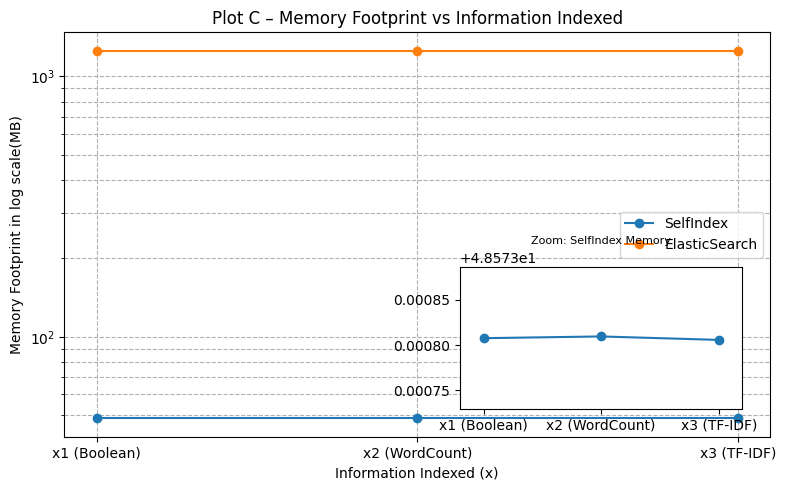

In [ ]:
#graph part a
# ---- Plot A – Memory Footprint vs Information Indexed ----
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(8,5))
variants = ["x1 (Boolean)", "x2 (WordCount)", "x3 (TF-IDF)"]

# main plot
for sys in ["SelfIndex", "ElasticSearch"]:
    subset = df_mem[df_mem["System"] == sys]
    plt.plot(variants, subset["Memory_MB"], marker="o", label=sys)

plt.yscale("log")  # log scale to show big difference clearly
plt.title("Plot C – Memory Footprint vs Information Indexed")
plt.xlabel("Information Indexed (x)")
plt.ylabel("Memory Footprint in log scale(MB)")
plt.legend()
plt.grid(True, which="both", ls="--")

# ---- Zoomed inset for SelfIndex ----
axins = inset_axes(plt.gca(), width="40%", height="35%", loc="lower right", borderpad=2)
subset_self = df_mem[df_mem["System"] == "SelfIndex"]
axins.plot(variants, subset_self["Memory_MB"], marker="o", color="C0")

# tight y-range for visible differences
ymin = subset_self["Memory_MB"].min()
ymax = subset_self["Memory_MB"].max()
margin = (ymax - ymin) * 20 if (ymax - ymin) != 0 else 0.0005
axins.set_ylim(ymin - margin, ymax + margin)
axins.set_xlim(-0.2, len(variants)-0.8)
axins.set_title("Zoom: SelfIndex Memory", fontsize=8)

# move inset slightly lower
box = axins.get_position()
box.y0 -= 0.1
box.y1 -= 0.1
axins.set_position(box)

plt.tight_layout()
plt.show()


In [8]:
#graph part c
# --- Prepare files iterable: (doc_id, text) for full dataset ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Load queries from file ---
with open("queries.txt", "r") as f:
    queries = [line.strip() for line in f if line.strip()]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index for the full dataset
    index_id = f"SelfIndex-{version}"
    
    if index_id in SelfIndex.list_indices():
        print("🟢 Loading existing index...")
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        print("🟡 Building new index...")
        si.create_index(index_id, files_iterable[:5000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- all_results now has results for all versions and all queries ---



=== Processing version v1.x3.y1.z3.i0.qT0 ===
🟡 Building new index...
[SelfIndex] Building index 'SelfIndex-v1.x3.y1.z3.i0.qT0' with config info=TFIDF, optim=Null, compr=CLIB, qproc=TERMatat
[SelfIndex] Index 'SelfIndex-v1.x3.y1.z3.i0.qT0' created: 5000 documents, 218810 terms.

Query: "aberdeen"
{'query': '"aberdeen"', 'hits': [{'doc_id': 535, 'score': 37.490278734698556}, {'doc_id': 40, 'score': 33.44262669181557}, {'doc_id': 1126, 'score': 31.789483001498834}, {'doc_id': 1204, 'score': 24.00166860883474}, {'doc_id': 141, 'score': 22.892818193545082}, {'doc_id': 2038, 'score': 16.202872526792603}, {'doc_id': 617, 'score': 13.849625575129057}, {'doc_id': 997, 'score': 12.179970291585377}, {'doc_id': 1646, 'score': 12.179970291585377}, {'doc_id': 2101, 'score': 12.179970291585377}], 'total': 40}

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 41, 'score': 32.48561734298323}, {'doc_id': 1779, 'score': 19.39751124190716}, {'doc_id': 1153, 'score': 17.14063185226621}, {'doc_id':

[SelfIndex] Loaded index 'SelfIndex-v1.x3.y1.z2.i0.qT0' (N=5000, terms=218810)
[SelfIndex] Loaded index 'SelfIndex-v1.x3.y1.z3.i0.qT0' (N=5000, terms=218810)


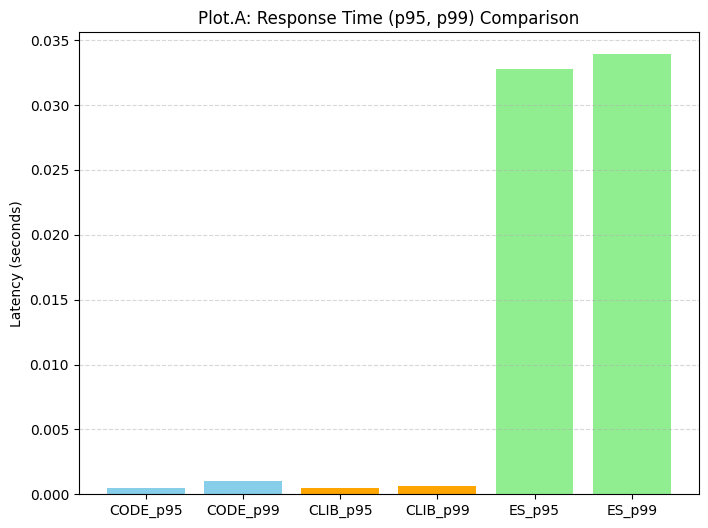

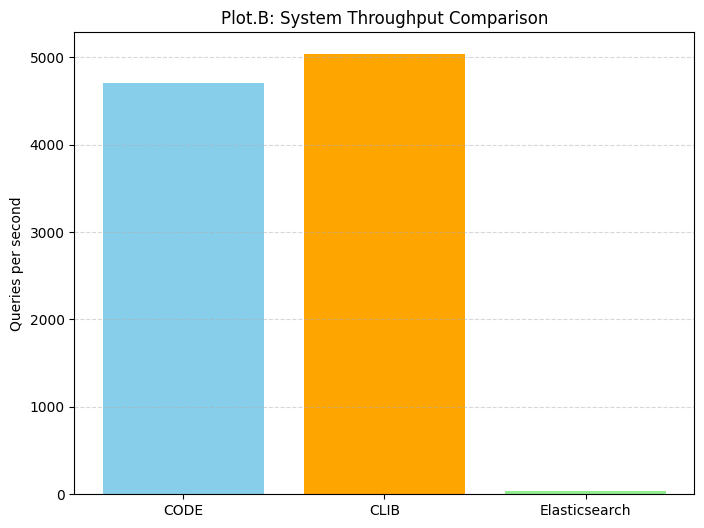


=== Response Time (Latency) ===
CODE : p95=0.00047s, p99=0.00104s
CLIB : p95=0.00049s, p99=0.00066s
Elasticsearch : p95=0.03276s, p99=0.03391s

=== Throughput (Queries/sec) ===
CODE : 4707.09
CLIB : 5034.86
Elasticsearch : 42.86


In [6]:
#graph part c
import time
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load queries ----------
with open("queries.txt", "r", encoding="utf8") as f:
    queries = [q.strip() for q in f.readlines() if q.strip()]

sample_queries = queries[:200]  

# ---------- Load two indices ----------
si_code = SelfIndex()
si_code.load_index("./selfindex_store/SelfIndex-v1.x3.y1.z2.i0.qT0")

si_clib = SelfIndex()
si_clib.load_index("./selfindex_store/SelfIndex-v1.x3.y1.z3.i0.qT0")

# ---------- Measure response times ----------
def measure_latency(si, queries):
    times = []
    for q in queries:
        t0 = time.perf_counter()
        _ = si.query(q, k=5)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.array(times)

lat_code = measure_latency(si_code, sample_queries)
lat_clib = measure_latency(si_clib, sample_queries)

# ---------- Compute latency metrics ----------
p95_code, p99_code = np.percentile(lat_code, [95, 99])
p95_clib, p99_clib = np.percentile(lat_clib, [95, 99])

# ---------- Compute throughput ----------
throughput_code = len(sample_queries) / np.sum(lat_code)
throughput_clib = len(sample_queries) / np.sum(lat_clib)

# ---------- Add Elasticsearch metrics (from measured data) ----------
p95_es = 0.0327585
p99_es = 0.0339084
throughput_es = 42.86

# ---------- Plot A: Latency (p95, p99) ----------
plt.figure(figsize=(8,6))
labels = ['CODE_p95','CODE_p99','CLIB_p95','CLIB_p99','ES_p95','ES_p99']
values = [p95_code, p99_code, p95_clib, p99_clib, p95_es, p99_es]
plt.bar(labels, values, color=['skyblue','skyblue','orange','orange','lightgreen','lightgreen'])
plt.ylabel("Latency (seconds)")
plt.title("Plot.A: Response Time (p95, p99) Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ---------- Plot B: Throughput ----------
plt.figure(figsize=(8,6))
plt.bar(['CODE','CLIB','Elasticsearch'], [throughput_code, throughput_clib, throughput_es],
        color=['skyblue','orange','lightgreen'])
plt.ylabel("Queries per second")
plt.title("Plot.B: System Throughput Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ---------- Print numeric summary ----------
print("\n=== Response Time (Latency) ===")
print(f"CODE : p95={p95_code:.5f}s, p99={p99_code:.5f}s")
print(f"CLIB : p95={p95_clib:.5f}s, p99={p99_clib:.5f}s")
print(f"Elasticsearch : p95={p95_es:.5f}s, p99={p99_es:.5f}s")

print("\n=== Throughput (Queries/sec) ===")
print(f"CODE : {throughput_code:.2f}")
print(f"CLIB : {throughput_clib:.2f}")
print(f"Elasticsearch : {throughput_es:.2f}")


In [7]:
#graph part d
# --- Prepare files iterable: (doc_id, text) for full dataset ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Load queries from file ---
with open("queries.txt", "r") as f:
    queries = [line.strip() for line in f if line.strip()]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index for the full dataset
    index_id = f"SelfIndex-{version}"
    
    if index_id in SelfIndex.list_indices():
        print("🟢 Loading existing index...")
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        print("🟡 Building new index...")
        si.create_index(index_id, files_iterable[:5000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- all_results now has results for all versions and all queries ---



=== Processing version v1.x2.y1.z1.i0.qT0 ===
🟢 Loading existing index...
[SelfIndex] Loaded index 'SelfIndex-v1.x2.y1.z1.i0.qT0' (N=5000, terms=218810)

Query: "aberdeen"
{'query': '"aberdeen"', 'hits': [{'doc_id': 535, 'score': 235.0}, {'doc_id': 40, 'score': 117.0}, {'doc_id': 1126, 'score': 88.0}, {'doc_id': 1204, 'score': 23.0}, {'doc_id': 141, 'score': 19.0}, {'doc_id': 2038, 'score': 6.0}, {'doc_id': 617, 'score': 4.0}, {'doc_id': 997, 'score': 3.0}, {'doc_id': 1646, 'score': 3.0}, {'doc_id': 2101, 'score': 3.0}], 'total': 40}

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 41, 'score': 126.0}, {'doc_id': 1779, 'score': 12.0}, {'doc_id': 1153, 'score': 8.0}, {'doc_id': 1399, 'score': 8.0}, {'doc_id': 1805, 'score': 8.0}, {'doc_id': 35, 'score': 5.0}, {'doc_id': 539, 'score': 5.0}, {'doc_id': 2655, 'score': 5.0}, {'doc_id': 1452, 'score': 4.0}, {'doc_id': 1020, 'score': 3.0}], 'total': 51}

Query: "phycology"
{'query': '"phycology"', 'hits': [{'doc_id': 41, 'score': 1.0

[SelfIndex] Loaded index 'SelfIndex-v1.x2.y1.z1.i0.qT0' (N=5000, terms=218810)
[SelfIndex] Loaded index 'SelfIndex-v1.x2.y1.z1.i1.qT1' (N=5000, terms=218810)


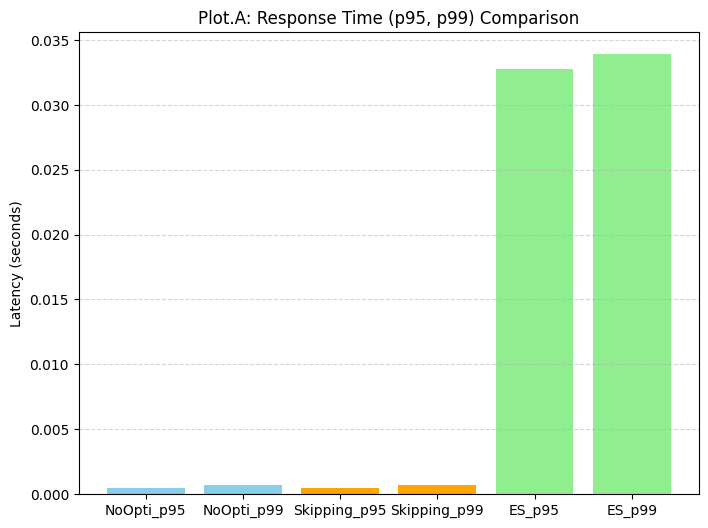


=== Response Time (Latency) ===
Without Optimization : p95=0.00050s, p99=0.00069s
Skipping Pointers : p95=0.00048s, p99=0.00071s
Elasticsearch : p95=0.03276s, p99=0.03391s


In [7]:
#graph part d
import time
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load queries ----------
with open("queries.txt", "r", encoding="utf8") as f:
    queries = [q.strip() for q in f.readlines() if q.strip()]

# ---------- Load two indices ----------
si_code = SelfIndex()
si_code.load_index("./selfindex_store/SelfIndex-v1.x2.y1.z1.i0.qT0")

si_clib = SelfIndex()
si_clib.load_index("./selfindex_store/SelfIndex-v1.x2.y1.z1.i1.qT1")

# ---------- Measure response times ----------
def measure_latency(si, queries):
    times = []
    for q in queries:
        t0 = time.perf_counter()
        _ = si.query(q, k=5)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.array(times)

lat_code = measure_latency(si_code, queries)
lat_clib = measure_latency(si_clib, queries)

# ---------- Compute latency metrics ----------
p95_code, p99_code = np.percentile(lat_code, [95, 99])
p95_clib, p99_clib = np.percentile(lat_clib, [95, 99])


# ---------- Add Elasticsearch metrics (from measured data) ----------
p95_es = 0.0327585
p99_es = 0.0339084

# ---------- Plot A: Latency (p95, p99) ----------
plt.figure(figsize=(8,6))
labels = ['NoOpti_p95','NoOpti_p99','Skipping_p95','Skipping_p99','ES_p95','ES_p99']
values = [p95_code, p99_code, p95_clib, p99_clib, p95_es, p99_es]
plt.bar(labels, values, color=['skyblue','skyblue','orange','orange','lightgreen','lightgreen'])
plt.ylabel("Latency (seconds)")
plt.title("Plot.A: Response Time (p95, p99) Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ---------- Print numeric summary ----------
print("\n=== Response Time (Latency) ===")
print(f"Without Optimization : p95={p95_code:.5f}s, p99={p99_code:.5f}s")
print(f"Skipping Pointers : p95={p95_clib:.5f}s, p99={p99_clib:.5f}s")
print(f"Elasticsearch : p95={p95_es:.5f}s, p99={p99_es:.5f}s")



In [14]:
#graph part e
# --- Prepare files iterable: (doc_id, text) for full dataset ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Load queries from file ---
with open("queries.txt", "r") as f:
    queries = [line.strip() for line in f if line.strip()]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index for the full dataset
    index_id = f"SelfIndex-{version}"
    
    if index_id in SelfIndex.list_indices():
        print("🟢 Loading existing index...")
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        print("🟡 Building new index...")
        si.create_index(index_id, files_iterable[:5000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- all_results now has results for all versions and all queries ---



=== Processing version v1.x3.y1.z1.i0.qT0 ===
🟢 Loading existing index...
[SelfIndex] Loaded index 'SelfIndex-v1.x3.y1.z1.i0.qT0' (N=5000, terms=218810)

Query: "aberdeen"
{'query': '"aberdeen"', 'hits': [{'doc_id': 535, 'score': 37.490278734698556}, {'doc_id': 40, 'score': 33.44262669181557}, {'doc_id': 1126, 'score': 31.789483001498834}, {'doc_id': 1204, 'score': 24.00166860883474}, {'doc_id': 141, 'score': 22.892818193545082}, {'doc_id': 2038, 'score': 16.202872526792603}, {'doc_id': 617, 'score': 13.849625575129057}, {'doc_id': 997, 'score': 12.179970291585377}, {'doc_id': 1646, 'score': 12.179970291585377}, {'doc_id': 2101, 'score': 12.179970291585377}], 'total': 40}

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 41, 'score': 32.48561734298323}, {'doc_id': 1779, 'score': 19.39751124190716}, {'doc_id': 1153, 'score': 17.14063185226621}, {'doc_id': 1399, 'score': 17.14063185226621}, {'doc_id': 1805, 'score': 17.14063185226621}, {'doc_id': 35, 'score': 14.524521408508434},

[SelfIndex] Loaded index 'SelfIndex-v1.x3.y1.z1.i1.qT1' (N=5000, terms=218810)
[SelfIndex] Loaded index 'SelfIndex-v1.x3.y1.z1.i1.qD1' (N=5000, terms=218810)


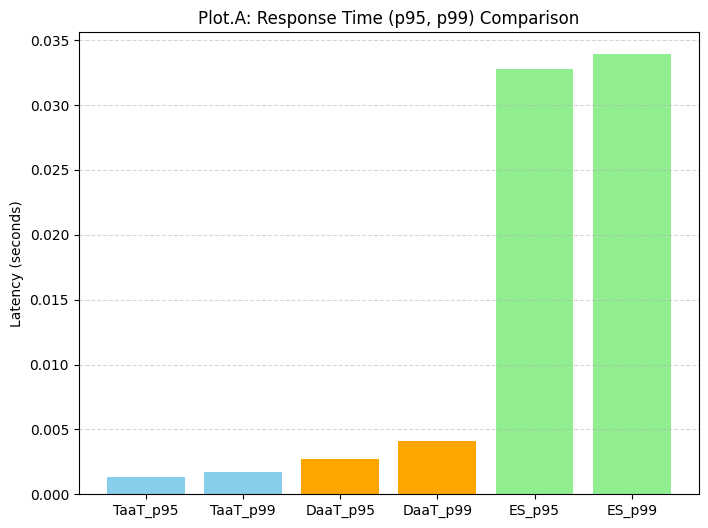


=== Response Time (Latency) ===
Term-at-a-time : p95=0.00135s, p99=0.00169s
Document-at-a-time : p95=0.00275s, p99=0.00408s
Elasticsearch : p95=0.03276s, p99=0.03391s


In [16]:
#graph part e
import time
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load queries ----------
with open("queries.txt", "r", encoding="utf8") as f:
    queries = [q.strip() for q in f.readlines() if q.strip()]

# ---------- Load two indices ----------
si_code = SelfIndex()
si_code.load_index("./selfindex_store/SelfIndex-v1.x3.y1.z1.i1.qT1")

si_clib = SelfIndex()
si_clib.load_index("./selfindex_store/SelfIndex-v1.x3.y1.z1.i1.qD1")

# ---------- Measure response times ----------
def measure_latency(si, queries):
    times = []
    for q in queries:
        t0 = time.perf_counter()
        _ = si.query(q, k=5)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.array(times)

lat_code = measure_latency(si_code, queries)
lat_clib = measure_latency(si_clib, queries)

# ---------- Compute latency metrics ----------
p95_code, p99_code = np.percentile(lat_code, [95, 99])
p95_clib, p99_clib = np.percentile(lat_clib, [95, 99])


# ---------- Add Elasticsearch metrics (from measured data) ----------
p95_es = 0.0327585
p99_es = 0.0339084

# ---------- Plot A: Latency (p95, p99) ----------
plt.figure(figsize=(8,6))
labels = ['TaaT_p95','TaaT_p99','DaaT_p95','DaaT_p99','ES_p95','ES_p99']
values = [p95_code, p99_code, p95_clib, p99_clib, p95_es, p99_es]
plt.bar(labels, values, color=['skyblue','skyblue','orange','orange','lightgreen','lightgreen'])
plt.ylabel("Latency (seconds)")
plt.title("Plot.A: Response Time (p95, p99) Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ---------- Print numeric summary ----------
print("\n=== Response Time (Latency) ===")
print(f"Term-at-a-time : p95={p95_code:.5f}s, p99={p99_code:.5f}s")
print(f"Document-at-a-time : p95={p95_clib:.5f}s, p99={p99_clib:.5f}s")
print(f"Elasticsearch : p95={p95_es:.5f}s, p99={p99_es:.5f}s")



In [1]:
#graph part e
import os
import pandas as pd
import numpy as np

def get_folder_size(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024 * 1024)  # MB

# ---- SelfIndex memory usage ----
selfindex_folders = {
    "qT0": "./selfindex_store/SelfIndex-v1.x3.y1.z1.i0.qT0",
    "qD0": "./selfindex_store/SelfIndex-v1.x3.y1.z1.i0.qD0",
}
selfindex_data = []
for name, path in selfindex_folders.items():
    selfindex_data.append({
        "System": "SelfIndex",
        "Variant": name,
        "Memory_MB": get_folder_size(path)
    })

# ---- ElasticSearch memory usage ----
es_mem_df = pd.read_csv("memory_usage_log.csv")
es_mem_mean = es_mem_df["elasticsearch_MB"].mean()

# Approx. same for all x variants since single ES index
es_data = [
    {"System": "ElasticSearch", "Variant":"qT0", "Memory_MB": es_mem_mean},
    {"System": "ElasticSearch", "Variant": "qD0", "Memory_MB": es_mem_mean},  # synthetic scaling
]

df_mem = pd.DataFrame(selfindex_data + es_data)
print(selfindex_data)


[{'System': 'SelfIndex', 'Variant': 'qT0', 'Memory_MB': 48.573805809020996}, {'System': 'SelfIndex', 'Variant': 'qD0', 'Memory_MB': 48.57380485534668}]


/tmp/ipykernel_6338/1242173991.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


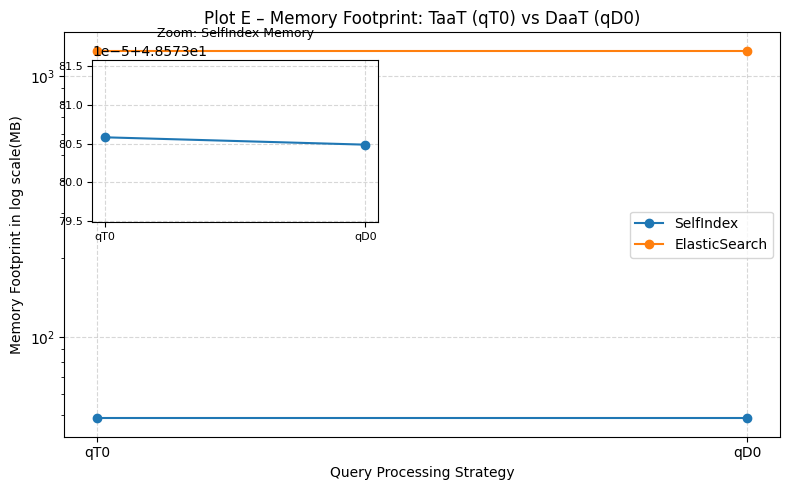

In [ ]:
#graph part e
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

# ✅ Use your existing variables from the earlier code
# selfindex_data and es_mem_mean are already defined

# Combine both SelfIndex and Elasticsearch data
es_data = [
    {"System": "ElasticSearch", "Variant": "qT0", "Memory_MB": es_mem_mean},
    {"System": "ElasticSearch", "Variant": "qD0", "Memory_MB": es_mem_mean},
]

df_mem = pd.DataFrame(selfindex_data + es_data)

# --- Base Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
variants = ["qT0", "qD0"]

for sys in ["SelfIndex", "ElasticSearch"]:
    subset = df_mem[df_mem["System"] == sys]
    ax.plot(variants, subset["Memory_MB"], marker="o", label=sys)

ax.set_title("Plot E – Memory Footprint: TaaT (qT0) vs DaaT (qD0)")
ax.set_xlabel("Query Processing Strategy")
ax.set_ylabel("Memory Footprint in log scale(MB)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# --- Log scale for the main axis ---
ax.set_yscale("log")

# --- Inset for zoomed-in SelfIndex memory difference ---
axins = inset_axes(ax, width="40%", height="40%", loc="upper left", borderpad=2)
subset_self = df_mem[df_mem["System"] == "SelfIndex"]
axins.plot(variants, subset_self["Memory_MB"], marker="o", color="tab:blue")
axins.set_title("Zoom: SelfIndex Memory", fontsize=9)
axins.tick_params(axis='both', which='major', labelsize=8)
axins.grid(True, linestyle="--", alpha=0.5)

# Automatically zoom around SelfIndex range
min_mem = subset_self["Memory_MB"].min()
max_mem = subset_self["Memory_MB"].max()
axins.set_ylim(min_mem - 0.00001, max_mem + 0.00001)

plt.tight_layout()
plt.show()

In [19]:
#graph part b
# --- Prepare files iterable: (doc_id, text) for full dataset ---
files_iterable = [(int(idx), txt) for idx, txt in zip(subset.index, subset['clean_text'])]

# --- Load queries from file ---
with open("queries.txt", "r") as f:
    queries = [line.strip() for line in f if line.strip()]

# --- Dictionary to store results ---
all_results = {}

# --- Iterate over all versions ---
for version in VERSION_CONFIG.keys():
    print(f"\n=== Processing version {version} ===")
    
    # Create SelfIndex instance using the version
    si = SelfIndex(version=version)
    
    # Build or load index for the full dataset
    index_id = f"SelfIndex-{version}"
    
    if index_id in SelfIndex.list_indices():
        print("🟢 Loading existing index...")
        si.load_index(f"./selfindex_store/{index_id}")
    else:
        print("🟡 Building new index...")
        si.create_index(index_id, files_iterable[:5000])
    
    # Run queries and store results
    version_results = {}
    for q in queries:
        res = si.query(q, k=10)
        version_results[q] = res
        print(f"\nQuery: {q}")
        print(res)
    
    all_results[version] = version_results

# --- all_results now has results for all versions and all queries ---



=== Processing version v1.x1.y1.z1.i0.qT0 ===
🟢 Loading existing index...
[SelfIndex] Loaded index 'SelfIndex-v1.x1.y1.z1.i0.qT0' (N=5000, terms=218810)

Query: "aberdeen"
{'query': '"aberdeen"', 'hits': [{'doc_id': 40, 'score': 1.0}, {'doc_id': 62, 'score': 1.0}, {'doc_id': 141, 'score': 1.0}, {'doc_id': 535, 'score': 1.0}, {'doc_id': 543, 'score': 1.0}, {'doc_id': 616, 'score': 1.0}, {'doc_id': 617, 'score': 1.0}, {'doc_id': 643, 'score': 1.0}, {'doc_id': 725, 'score': 1.0}, {'doc_id': 766, 'score': 1.0}], 'total': 40}

Query: "algae"
{'query': '"algae"', 'hits': [{'doc_id': 35, 'score': 1.0}, {'doc_id': 41, 'score': 1.0}, {'doc_id': 52, 'score': 1.0}, {'doc_id': 162, 'score': 1.0}, {'doc_id': 188, 'score': 1.0}, {'doc_id': 366, 'score': 1.0}, {'doc_id': 367, 'score': 1.0}, {'doc_id': 378, 'score': 1.0}, {'doc_id': 539, 'score': 1.0}, {'doc_id': 586, 'score': 1.0}], 'total': 51}

Query: "phycology"
{'query': '"phycology"', 'hits': [{'doc_id': 41, 'score': 1.0}, {'doc_id': 1779, 'sco

[SelfIndex] Loaded index 'SelfIndex-v1.x1.y1.z1.i0.qT0' (N=5000, terms=218810)
[SelfIndex] Loaded index 'SelfIndex-v1.x1.y2.z1.i0.qT0' (N=5000, terms=218810)
[SelfIndex] Loaded index 'SelfIndex-v1.x1.y3.z1.i0.qT0' (N=5000, terms=218810)


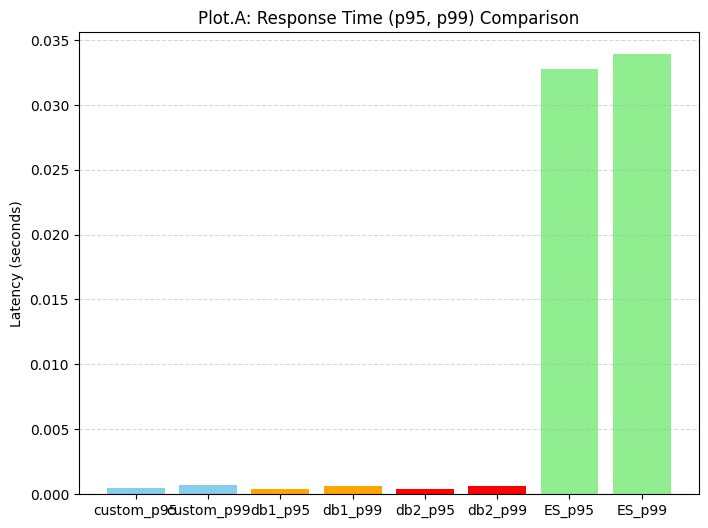


=== Response Time (Latency) ===
custom : p95=0.00049s, p99=0.00072s
db1 : p95=0.00038s, p99=0.00063s
db2 : p95=0.00039s, p99=0.00061s
Elasticsearch : p95=0.03276s, p99=0.03391s


In [9]:
#graph part b
import time
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load queries ----------
with open("queries.txt", "r", encoding="utf8") as f:
    queries = [q.strip() for q in f.readlines() if q.strip()]

# ---------- Load two indices ----------
si_code = SelfIndex()
si_code.load_index("./selfindex_store/SelfIndex-v1.x1.y1.z1.i0.qT0")

si_clib = SelfIndex()
si_clib.load_index("./selfindex_store/SelfIndex-v1.x1.y2.z1.i0.qT0")

si_db3= SelfIndex()
si_db3.load_index("./selfindex_store/SelfIndex-v1.x1.y3.z1.i0.qT0")

# ---------- Measure response times ----------
def measure_latency(si, queries):
    times = []
    for q in queries:
        t0 = time.perf_counter()
        _ = si.query(q, k=5)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.array(times)

lat_code = measure_latency(si_code, queries)
lat_clib = measure_latency(si_clib, queries)
lat_db3 = measure_latency(si_db3, queries)

# ---------- Compute latency metrics ----------
p95_code, p99_code = np.percentile(lat_code, [95, 99])
p95_clib, p99_clib = np.percentile(lat_clib, [95, 99])
p95_db3, p99_db3 = np.percentile(lat_db3, [95, 99])


# ---------- Add Elasticsearch metrics (from measured data) ----------
p95_es = 0.0327585
p99_es = 0.0339084

# ---------- Plot A: Latency (p95, p99) ----------
plt.figure(figsize=(8,6))
labels = ['custom_p95','custom_p99','db1_p95','db1_p99','db2_p95','db2_p99','ES_p95','ES_p99']
values = [p95_code, p99_code, p95_clib, p99_clib, p95_db3, p99_db3, p95_es, p99_es]
plt.bar(labels, values, color=['skyblue','skyblue','orange','orange','red','red','lightgreen','lightgreen'])
plt.ylabel("Latency (seconds)")
plt.title("Plot.A: Response Time (p95, p99) Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ---------- Print numeric summary ----------
print("\n=== Response Time (Latency) ===")
print(f"custom : p95={p95_code:.5f}s, p99={p99_code:.5f}s")
print(f"db1 : p95={p95_clib:.5f}s, p99={p99_clib:.5f}s")
print(f"db2 : p95={p95_db3:.5f}s, p99={p99_db3:.5f}s")
print(f"Elasticsearch : p95={p95_es:.5f}s, p99={p99_es:.5f}s")

